## Machine Intelligence 4: Belugas on the run

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
training_ridge = np.loadtxt('TrainingRidge.csv', delimiter = ',', skiprows = 1)
validation_ridge = np.loadtxt('ValidationRidge.csv', delimiter = ',', skiprows = 1)

## Part 1: Preprocessing

Text(0.5, 1.0, 'Validation Set')

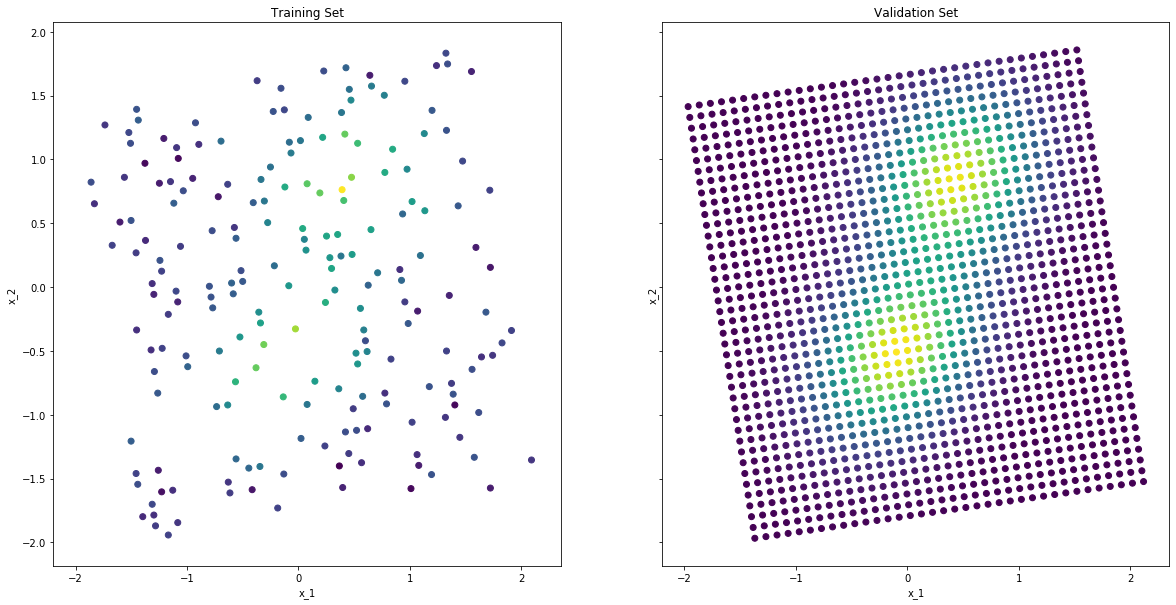

In [164]:
#Compute centered data:

training_vecs = training_ridge[:,0:2]
validation_vecs = validation_ridge[:,0:2]

centre = lambda ls, ms: np.array(list(map(lambda x: x - np.mean(ms, axis = 0), ls)))
   
t_centred = centre(training_vecs, training_vecs)
v_centred = centre(validation_vecs, training_vecs)
C_t = np.cov(t_centred.T)

e_vals, e_vecs = np.linalg.eig(C_t)
e_val_matr = np.identity(2) * e_vals

Lambda = np.linalg.inv(np.sqrt(e_val_matr))
Lambda_E = Lambda.dot(e_vecs.T)

sphere = lambda x: Lambda_E.dot(x)
sphered_t = np.array(list(map(sphere, t_centred)))
sphered_v = np.array(list(map(sphere, v_centred)))


fig, (ax1, ax2) = plt.subplots(1,2, sharey = True, sharex = True, figsize = (20,10))

ax1.scatter(sphered_t[:,0], sphered_t[:,1], c =  training_ridge[:,2])
ax1.set_xlabel('x_1')
ax1.set_ylabel('x_2')
ax1.set_title('Training Set')
ax2.scatter(sphered_v[:,0], sphered_v[:,1], c =  validation_ridge[:,2])
ax2.set_xlabel('x_1')
ax2.set_ylabel('x_2')
ax2.set_title('Validation Set')

## Part 2: Monomials 

In [214]:
#First we compute the different monomials:

k = np.arange(0,10)
pairs = np.zeros((55,2))

#Find all pairs of numbers $l and $m with m + l = k:

pairs_func = lambda k: list(filter(lambda xy: xy[0] + xy[1] == k, [(m,l) for l in range(10) for m in range(10)]))

i = 0
for ki in k:
    pairs[i: i + ki + 1] = pairs_func(ki)
    i = i + ki + 1
    
#We get the transformed data by applying the pairs as exponents to the centred data, then multiplying:

monomials = lambda x: np.prod(np.array(list(map(lambda exp: x**exp, pairs))), axis = 2)

y = lambda x, w: w.T.dot(phi(x))

(55, 1476)
(55, 1476)


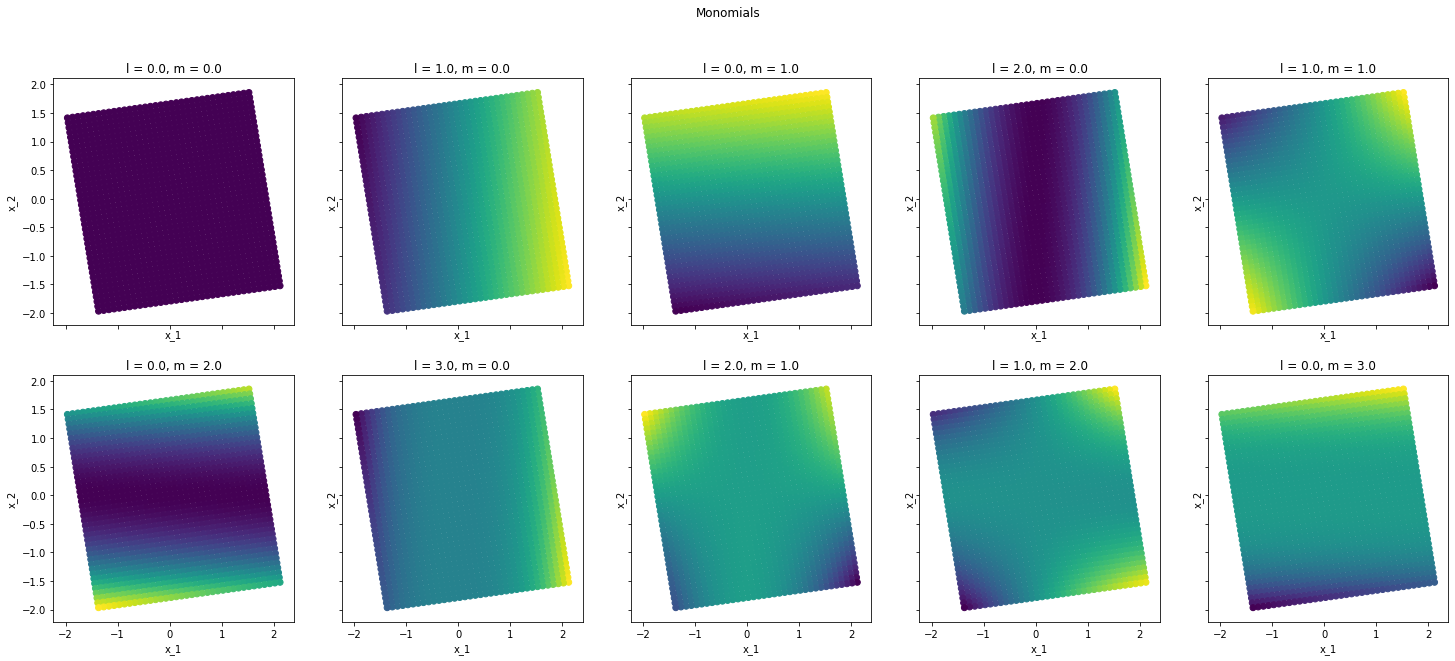

(55, 200) (55, 200)


In [213]:
#$phi: a list of functions that return a monomial for an input vector

monoms_y = monomials(sphered_v)

# Part i: print the sphered validation set using the first 10 monomials:

fig, axs = plt.subplots(2,5, sharex = True, sharey = True, figsize = (25,10))

plt.suptitle('Monomials')

for i in range (2):
    for j in range (5):
    
        axs[i,j].scatter(sphered_v[:,0], sphered_v[:,1], c = monoms_y[35*i + j])
        axs[i,j].set_title('l = {0}, m = {1}'.format(pairs[5*i + j][0], pairs[5*i + j][1]))
        axs[i,j].set_xlabel('x_1')
        axs[i,j].set_ylabel('x_2')
        
plt.show()

print(monoms.shape, monoms_2.shape)

(55,)
(1476,)


<Figure size 432x288 with 0 Axes>

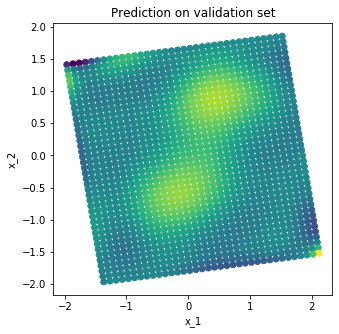

In [215]:
#Part ii: Plot the predicted values
#Keeping w_star generic for later use:

monoms_x = monomials(sphered_t)

w_star = lambda w, y, A: np.linalg.inv(w.dot(w.T) + A).dot(np.dot(w, y.T))

print(w_star(monoms_x, training_ridge[:,2], np.zeros((55,55))).shape)

y = w_star(monoms_x, training_ridge[:,2], np.zeros((55,55))).T.dot(monoms_y)

print(y.shape)

plt.figure()
fig, axs = plt.subplots(figsize = (5,5))
plt.scatter(sphered_v[:,0], sphered_v[:,1], c = y)
plt.title('Prediction on validation set')
plt.xlabel('x_1')
plt.ylabel('x_2')

plt.show()

## Part 3: Regularisation

In [216]:
lambdas = [10**z for z in np.arange(-4,4.1, 0.1)]
divisions = lambda x, n: np.array(np.split(x, n))

mse = lambda x,y: np.mean((x-y)**2 / 2)

#Get the training data for the training runs:

training_data = np.zeros((200,3))
training_data[:,0:2] = sphered_t
training_data[:,2] = training_ridge[:,2]


In [217]:
def ten_fold (data, lambdas):
    
    divs = divisions(data, 10)
    
    ms = np.zeros((len(lambdas)))
    sd = np.zeros((len(lambdas)))
    
    for ireg, reg in np.ndenumerate(lambdas):
        
        dist = np.zeros(10)
        
        for idiv in range(10):
            
            test_divs = divs[idiv]
            
            dims = divs.shape[0] * divs.shape[1] - divs.shape[1]
            
            #Delete a different portion of the split on very iteration:
            
            training_divs = np.array([divs[i] for i in np.delete(np.arange(10), idiv)]).reshape(dims,3)
            
            monoms_training = monomials(training_divs[:,0:2])
            
            monoms_test = monomials(test_divs[:,0:2])
            
            w_opt =  w_star(monoms_training, training_divs[:,2], reg * np.identity((55)))
            
            out = w_opt.T.dot(monoms_test)
            
            dist[idiv] = mse(out, test_divs[:,2])
        
        ms[ireg] = dist.mean()
        sd[ireg] = dist.std()
                   
    return {'Mean distance': ms, 'Standard deviation': sd}
    
ms = ten_fold(training_data, lambdas)["Mean distance"]
sd = ten_fold(training_data, lambdas)["Standard deviation"]

best_lambda = lambdas[np.argmin(ms)]
print("Best lambda:", best_lambda, "\nBest MSE:", np.min(ms))

Best lambda: 5.011872336272776 
Best MSE: 25.15274956968858


Text(0, 0.5, 'Mean error')

<Figure size 432x288 with 0 Axes>

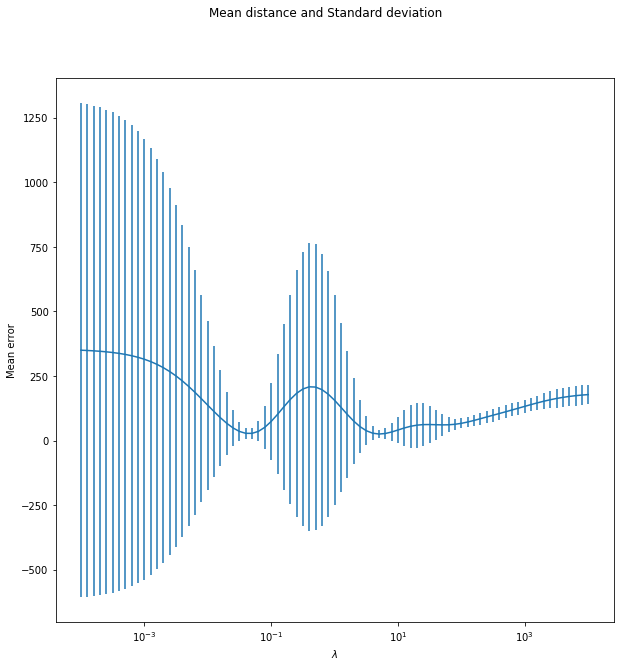

In [233]:
plt.figure()        
     
fig, axs = plt.subplots(figsize = (10,10))

plt.suptitle('Mean distance and Standard deviation')

axs.errorbar(lambdas, ms, yerr = sd)
axs.set_xscale("log")
axs.set_xlabel(r'$\lambda$')
axs.set_ylabel('Mean error')

Qualitatively this makes a lot of sense. Geometrically speaking, the quadratic error penalises weights that are outside a circle, pulling the weight vector toward that circle. However, once the circumference of that circle is reached, the regularised error no longer decreases, whereas the performance error still keeps increasing. Therefore, the qualititive prediction is that the error should dercrease until we hit a bump somewhere around 0, then decrease again and, finally, increase again because of the increase in regularisation error. This, in fact, is what we see.




The MSE of the model on the validation set is 12.330429340633284


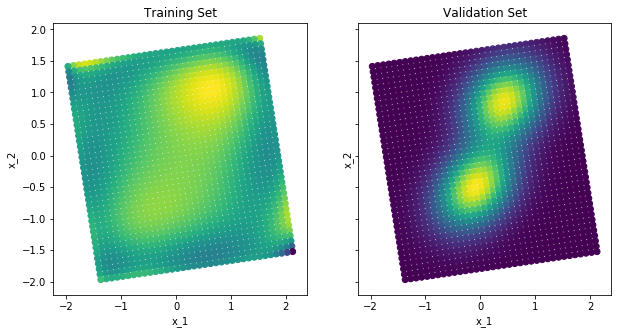

In [235]:
#Train the model on the original set and test on the validation set:

monoms_training = monomials(sphered_t)
monoms_valid = monomials(sphered_v)

w_best = w_star(monoms_training, training_ridge[:,2], best_lambda * np.identity((55)))

out = w_best.T.dot(monoms_valid)

fig, (ax1, ax2) = plt.subplots(1,2, sharey = True, sharex = True, figsize = (10,5))

ax1.scatter(sphered_v[:,0], sphered_v[:,1], c = out_new)
ax1.set_xlabel('x_1')
ax1.set_ylabel('x_2')
ax1.set_title('Training Set')
ax2.scatter(sphered_v[:,0], sphered_v[:,1], c =  validation_ridge[:,2])
ax2.set_xlabel('x_1')
ax2.set_ylabel('x_2')
ax2.set_title('Validation Set')

print('The MSE of the model on the validation set is', mse(out, validation_ridge[:,2]))

It seems like (from comparisons with other students) that the performance is a little suboptimal here. However, that may be due to the fact that we are dividing the training data differently. To some extend this is just a matter of how the data is ordered. We tried randomly shuffling the data before dividing it up using *np.split*, we got different $\lambda$ values every time. Choosing the initial split therefore seems to push us into a minimum on the right side of the 'bump' on the graph above, whereas it's apparently better to end up in the minimum to the left of the bump. However, the shape of our predictions *does* approximate the shape of our validation set to some degree. So we thought we were fine. 

In [239]:
#Part (d):

#Make the validation set the test set and perform sphering operations:
 
v_centred_new = centre(validation_vecs, validation_vecs)
v_sphered_new = np.array(list(map(sphere, v_centred)))[0:1470]

#For now, we'll throw away the last six data points, so we can run the ten-fold cross-validation 
#with the existing code (it seems like np.split wasn't really the best choice, we can try using array_split later):

training_data_new = np.zeros((1470,3))
training_data_new[:,0:2] = v_sphered_new
training_data_new[:,2] = validation_ridge[0:1470:,2]

ms_new = ten_fold(training_data_new, lambdas)["Mean distance"]
sd_new = ten_fold(training_data_new, lambdas)["Standard deviation"]
best_lambda_new = lambdas[np.argmin(ms_new)]

w_best_new = w_star(monoms_training, training_ridge[:,2], best_lambda_new * np.identity((55)))

out_new = w_best_new.T.dot(monoms_valid)


print("Best lambda:", best_lambda_new, "\nBest MSE:", np.min(ms_new))
print('The MSE of the model on the validation set is', mse(out_new, validation_ridge[:,2]))

Best lambda: 0.039810717055349935 
Best MSE: 33.18245730098937
The MSE of the model on the validation set is 5.008156245124342


Funnily enough, this is apparently the correct $\lambda$. But the MSE still seems a little high. At the very least – as we should expect – the validation error when training on the validation set is much smaller than when training on the training set.

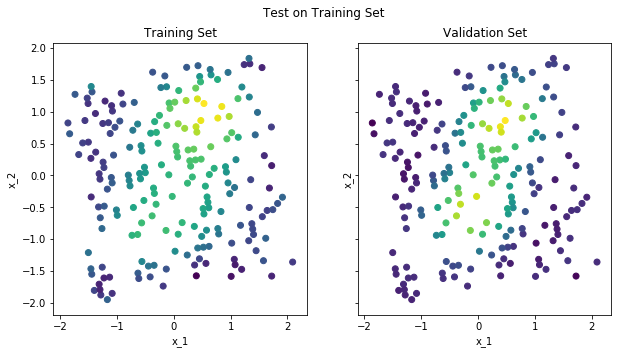

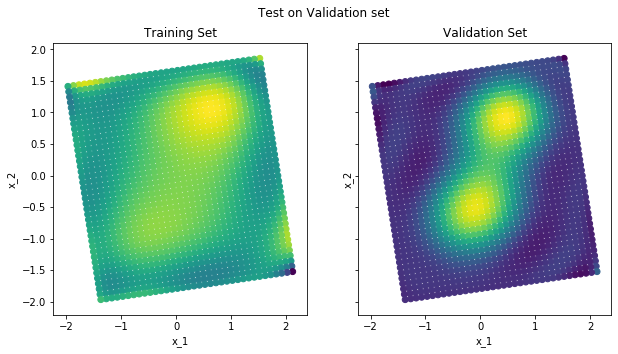

In [223]:
#Part (e):


#Part (i): test both functions on the training set

w_opt = w_star(monoms_training, training_ridge[:,2], best_lambda * np.identity((55)))
out_training = w_opt.T.dot(monoms_training)
w_best = w_star(monoms_valid, validation_ridge[:,2], best_lambda_new * np.identity((55)))
out_training_valid = w_best.T.dot(monoms_training)


fig, (ax1, ax2) = plt.subplots(1,2, sharey = True, sharex = True, figsize = (10,5))

plt.suptitle('Test on Training Set')

ax1.scatter(sphered_t[:,0], sphered_t[:,1], c = out_training)
ax1.set_xlabel('x_1')
ax1.set_ylabel('x_2')
ax1.set_title('Training Set')
ax2.scatter(sphered_t[:,0], sphered_t[:,1], c =  out_training_valid)
ax2.set_xlabel('x_1')
ax2.set_ylabel('x_2')
ax2.set_title('Validation Set')

plt.show()

#Part (ii): test both functions on the validation set

w_opt = w_star(monoms_training, training_ridge[:,2], best_lambda * np.identity((55)))
out_training = w_opt.T.dot(monoms_valid)
w_best = w_star(monoms_valid, validation_ridge[:,2], best_lambda_new * np.identity((55)))
out_training_valid = w_best.T.dot(monoms_valid)

fig, (ax1, ax2) = plt.subplots(1,2, sharey = True, sharex = True, figsize = (10,5))

plt.suptitle('Test on Validation set')

ax1.scatter(sphered_v[:,0], sphered_v[:,1], c = out_training)
ax1.set_xlabel('x_1')
ax1.set_ylabel('x_2')
ax1.set_title('Training Set')
ax2.scatter(sphered_v[:,0], sphered_v[:,1], c =  out_training_valid)
ax2.set_xlabel('x_1')
ax2.set_ylabel('x_2')
ax2.set_title('Validation Set')

plt.show()

